# Portfolio Analytics, Sharpe Ratio, Optimization, Order Books, Short Selling, and CAPM — Self‑Guided Notes


These notes are **self-contained** and runnable **offline**. You’ll simulate price series, compute portfolio statistics, build a Sharpe‑ratio Monte Carlo, (optionally) solve an **optimization** with SciPy (falls back gracefully if SciPy isn’t available), draw the **efficient frontier**, and review market microstructure (order books, HFT), **short selling**, **CAPM**, and **stock splits/dividends**.  
Each section follows a pattern: **What & Why → Steps → Worked Example → Checks → Exercise (Solved).**

> Tip: Run cells **top‑to‑bottom**. No internet or external data is required.


## 0) Setup — imports, reproducibility, helpers

In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Reproducibility
rng = np.random.default_rng(42)

# Matplotlib: one figure per chart; do not set styles or colors.
def newfig():
    plt.figure(figsize=(10, 6))

BUSINESS_DAYS_PER_YEAR = 252

def annualize_return(daily_ret_mean):
    """Annualize a *mean daily* return (arithmetic)."""
    return (1 + daily_ret_mean)**BUSINESS_DAYS_PER_YEAR - 1

def annualize_vol(daily_ret_std):
    """Annualize a *daily* std (volatility)."""
    return daily_ret_std * np.sqrt(BUSINESS_DAYS_PER_YEAR)

def sharpe_ratio(daily_returns, risk_free_annual=0.0):
    """Annualized Sharpe using daily returns.
    risk_free_annual is annual rate (e.g., 0.02 for 2%)."""
    rf_daily = (1 + risk_free_annual)**(1/BUSINESS_DAYS_PER_YEAR) - 1
    excess = daily_returns - rf_daily
    mean_excess = np.nanmean(excess)
    std = np.nanstd(daily_returns, ddof=0)
    if std == 0 or np.isnan(std):
        return np.nan
    daily_sr = mean_excess / std
    return daily_sr * np.sqrt(BUSINESS_DAYS_PER_YEAR)


## 1) Portfolio basics: weights, returns, and value

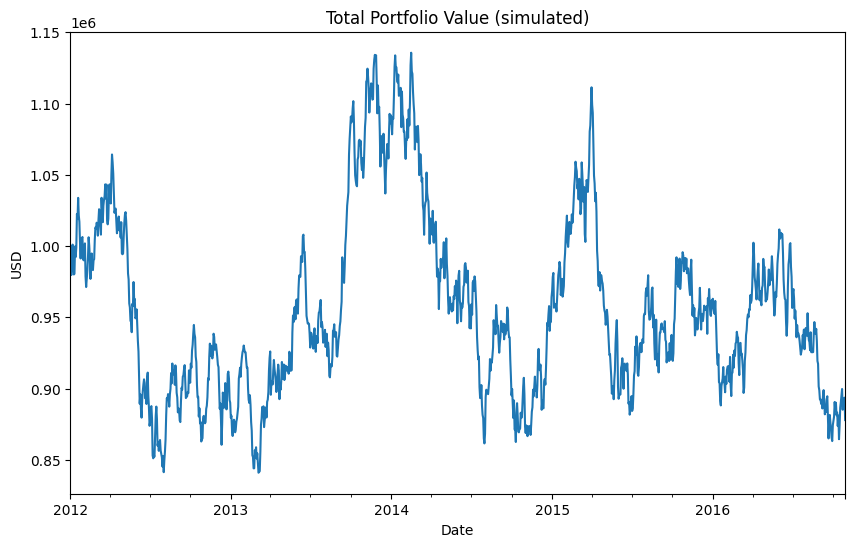

<Figure size 1000x600 with 0 Axes>

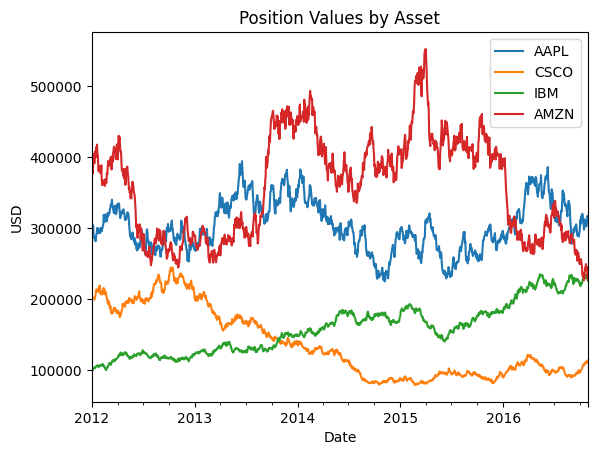

In [2]:

# --- Simulate 5 years of daily prices for 4 assets ---
n_years = 5
n_days = BUSINESS_DAYS_PER_YEAR * n_years
dates = pd.bdate_range("2012-01-02", periods=n_days)

# GBM parameters per asset (mu: drift, sigma: volatility)
mus = np.array([0.18, 0.10, 0.06, 0.22])        # annualized drift (illustrative)
sigmas = np.array([0.30, 0.22, 0.18, 0.35])     # annualized vol
starts = np.array([150.0, 25.0, 120.0, 180.0])

# Convert annual params to daily
mu_d = mus / BUSINESS_DAYS_PER_YEAR
sigma_d = sigmas / np.sqrt(BUSINESS_DAYS_PER_YEAR)

prices = {}
for i, name in enumerate(["AAPL","CSCO","IBM","AMZN"]):
    shocks = rng.normal(0, 1, size=n_days)
    increments = (mu_d[i] - 0.5 * sigma_d[i]**2) + sigma_d[i]*shocks
    path = starts[i] * np.exp(np.cumsum(increments))
    prices[name] = path

prices = pd.DataFrame(prices, index=dates)

# Normalize series to start at 1
norm = prices / prices.iloc[0]

# Pick weights (must sum to 1)
weights = pd.Series([0.30, 0.20, 0.10, 0.40], index=prices.columns)

# Compute daily (arithmetic) returns
daily_ret = prices.pct_change().dropna()

# Portfolio daily return = weighted sum of asset daily returns
port_daily = (daily_ret * weights).sum(axis=1)

# Cumulative return from $1 initial (i.e., growth of 1)
port_cum = (1 + port_daily).cumprod()

# Build positions from an initial capital
initial_capital = 1_000_000.0
position_values = norm.mul(weights, axis=1) * initial_capital  # allocation by normalized prices
total_value = position_values.sum(axis=1)

newfig(); total_value.plot(); plt.title("Total Portfolio Value (simulated)"); plt.xlabel("Date"); plt.ylabel("USD"); plt.show()

newfig(); position_values.plot(); plt.title("Position Values by Asset"); plt.xlabel("Date"); plt.ylabel("USD"); plt.legend(); plt.show()


### Exercise 1 (Solved): Change weights and recompute

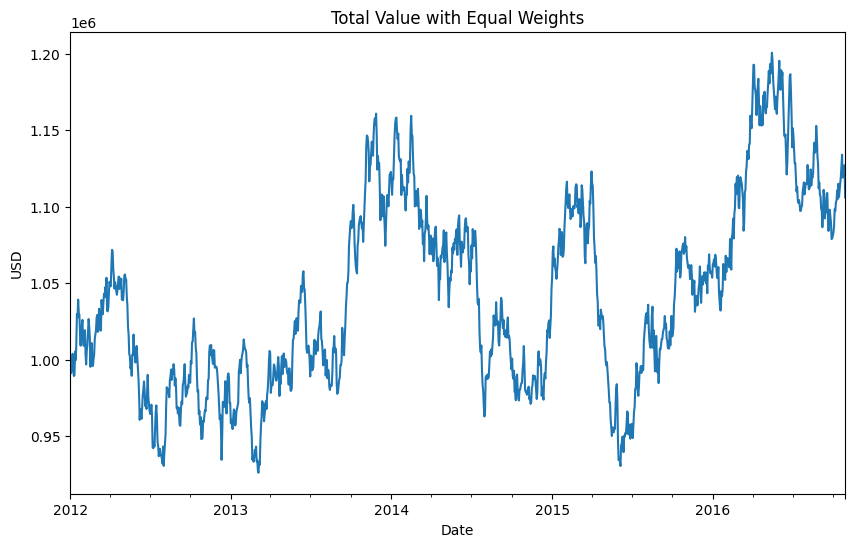

In [3]:

# SOLUTION
eq_weights = pd.Series([0.25,0.25,0.25,0.25], index=prices.columns)
eq_port_daily = (daily_ret * eq_weights).sum(axis=1)
eq_total_value = (norm.mul(eq_weights, axis=1) * initial_capital).sum(axis=1)

newfig(); eq_total_value.plot(); plt.title("Total Value with Equal Weights"); plt.xlabel("Date"); plt.ylabel("USD"); plt.show()


## 2) Sharpe Ratio: risk-adjusted performance

**Interpretation:**  
- **Sharpe > 1**: decent risk-adjusted performance  
- **Sharpe > 2**: very good  
- **Sharpe < 1**: either low returns or too much volatility  

Sharpe helps compare **different portfolios or strategies** on a fair basis:  
"How much return do I get per unit of risk?"


In [4]:

mean_daily = port_daily.mean()
std_daily  = port_daily.std(ddof=0)

ann_ret = annualize_return(mean_daily)
ann_vol = annualize_vol(std_daily)
ann_sr  = sharpe_ratio(port_daily, risk_free_annual=0.0)

print(f"Annualized return: {ann_ret:.2%}")
print(f"Annualized volatility: {ann_vol:.2%}")
print(f"Annualized Sharpe (rf=0%): {ann_sr:.3f}")


Annualized return: -0.54%
Annualized volatility: 17.20%
Annualized Sharpe (rf=0%): -0.032


### Exercise 2 (Solved): Non‑zero risk‑free rate

In [5]:

sr_2pct = sharpe_ratio(port_daily, risk_free_annual=0.02)
print(f"Annualized Sharpe (rf=2%): {sr_2pct:.3f}")


Annualized Sharpe (rf=2%): -0.147


## 3) Log vs arithmetic returns

### 📏 Why Compare Log vs Arithmetic Returns?

- **Arithmetic returns** are intuitive but cannot be added directly over time.  
- **Log returns** are additive: sum of daily log returns = log of total return.  

Log returns are preferred in many models (e.g., Black-Scholes) because they assume prices follow a log-normal distribution.


,AAPL,CSCO,IBM,AMZN
2012-01-03,-0.018937,0.001652,0.020592,-0.039414
2012-01-04,0.014827,0.011394,-0.002248,-0.020008
2012-01-05,0.018479,-0.005879,-0.020038,0.030900


,AAPL,CSCO,IBM,AMZN
2012-01-03,-0.019118,0.001651,0.020383,-0.040212
2012-01-04,0.014718,0.011329,-0.002250,-0.020211
2012-01-05,0.018311,-0.005896,-0.020242,0.030432


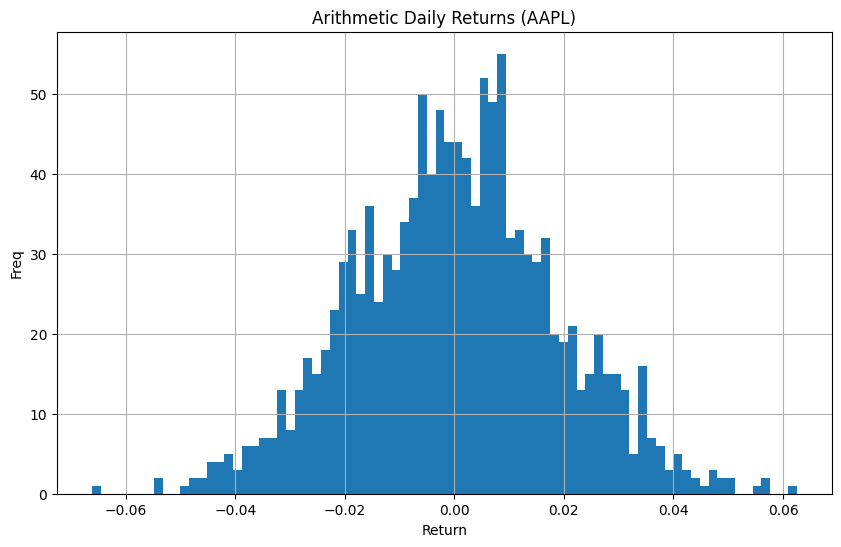

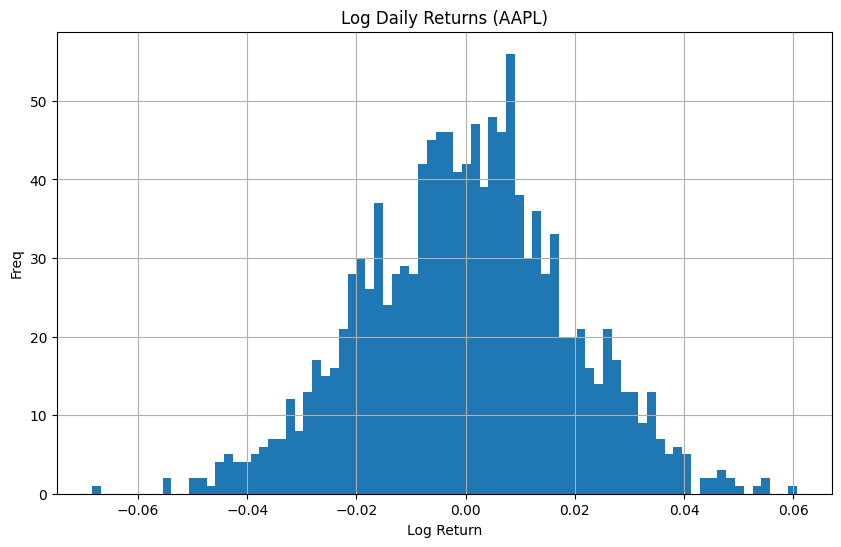

In [6]:

arith = prices.pct_change().dropna()
logret = np.log(prices / prices.shift(1)).dropna()

display(arith.head(3))
display(logret.head(3))

newfig(); arith["AAPL"].hist(bins=80); plt.title("Arithmetic Daily Returns (AAPL)"); plt.xlabel("Return"); plt.ylabel("Freq"); plt.show()
newfig(); logret["AAPL"].hist(bins=80); plt.title("Log Daily Returns (AAPL)"); plt.xlabel("Log Return"); plt.ylabel("Freq"); plt.show()


## 4) Monte Carlo allocations and maximum Sharpe

**Interpretation:**  
The Monte Carlo scatter shows all random portfolios in risk-return space:  
- Left-most points = minimum risk portfolios  
- Upper-left "edge" = **efficient frontier** (best return for each risk level)  
- The portfolio with the maximum Sharpe lies **tangent** to the capital market line.


Best random allocation (weights):
AAPL    0.237
CSCO    0.005
IBM     0.724
AMZN    0.034
dtype: float64
Best Sharpe ~ 0.783 | ann return 11.57% | ann vol 14.78%


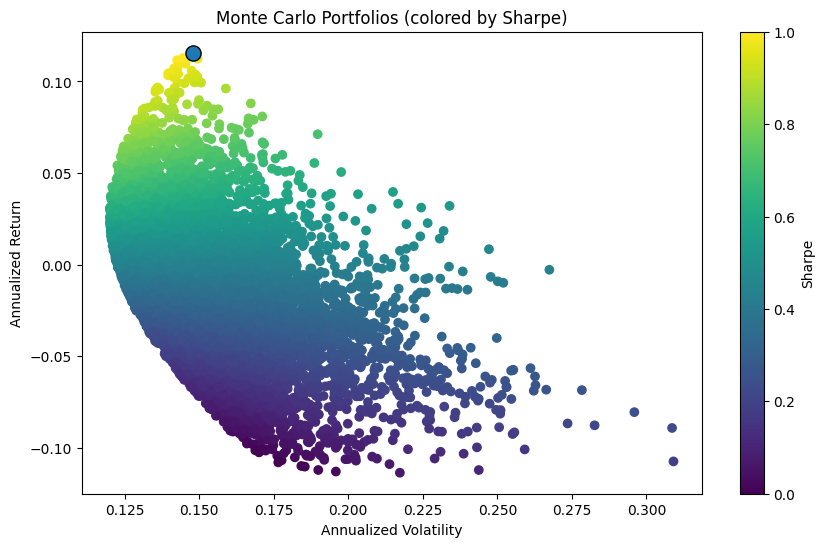

In [7]:

# Precompute from log returns
mu_log = logret.mean() * BUSINESS_DAYS_PER_YEAR               # approx annualized
cov_log = logret.cov() * BUSINESS_DAYS_PER_YEAR               # annualized covariance

def rand_weights(n, rng):
    w = rng.random(n)
    return w / w.sum()

def portfolio_return_vol(weights, mu, cov):
    ann_ret = float(np.dot(weights, mu))
    ann_vol = float(np.sqrt(weights @ cov.values @ weights))
    return ann_ret, ann_vol

N = 8000
rets = np.empty(N)
vols = np.empty(N)
srs  = np.empty(N)
W    = np.empty((N, len(mu_log)))

for i in range(N):
    w = rand_weights(len(mu_log), rng)
    r, v = portfolio_return_vol(w, mu_log.values, cov_log)
    rets[i] = r
    vols[i] = v
    srs[i]  = r / v if v > 0 else np.nan
    W[i] = w

best_idx = np.nanargmax(srs)
best_w   = W[best_idx]
best_r, best_v = rets[best_idx], vols[best_idx]
best_sr  = srs[best_idx]

print("Best random allocation (weights):")
print(pd.Series(best_w, index=prices.columns).round(3))
print(f"Best Sharpe ~ {best_sr:.3f} | ann return {best_r:.2%} | ann vol {best_v:.2%}")

newfig()
plt.scatter(vols, rets, c=srs)  # default colormap
plt.scatter([best_v], [best_r], s=120, edgecolors="black")
plt.xlabel("Annualized Volatility")
plt.ylabel("Annualized Return")
plt.title("Monte Carlo Portfolios (colored by Sharpe)")
plt.colorbar(label="Sharpe")
plt.show()


## 5) Optimization & Efficient Frontier (Markowitz)

### 🎯 Goal of Optimization

Here we solve for **portfolio weights** that:
- Maximize the Sharpe ratio  
- Respect constraints (weights sum to 1, no shorting unless allowed)

This is a direct application of **Markowitz Modern Portfolio Theory**.


**Interpretation:**  
The resulting weights show the "ideal" portfolio mix given:
- Our estimated expected returns
- Covariance matrix
- Risk-free rate assumption

Compare these weights with equal-weighted portfolio to see the impact of optimization.


Optimized weights (max Sharpe):
AAPL    0.016
CSCO    0.000
IBM     0.984
AMZN    0.000
dtype: float64
Sharpe ~ 0.918 | ann return 16.03% | ann vol 17.47%


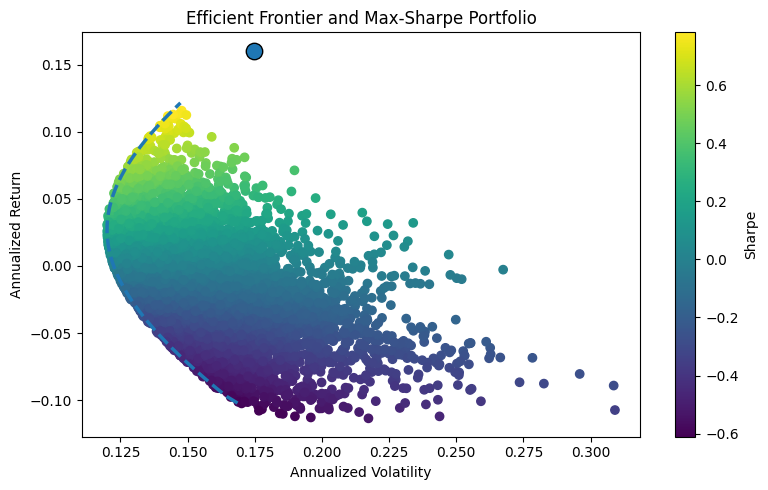

In [9]:
# --- SciPy (si está disponible) ---
try:
    from scipy.optimize import minimize
    SCIPY_OK = True
except Exception:
    SCIPY_OK = False

# --- Bounds y restricciones ---
bounds = [(0.0, 1.0)] * len(mu_log)

def cons_sum_to_1(w):
    return np.sum(w) - 1.0

constraints_sum = ({'type': 'eq', 'fun': cons_sum_to_1},)

# --- Objetivo: maximizar Sharpe (minimizamos el negativo) ---
def neg_sharpe(w, mu, cov, rf=0.0):
    # OJO: aquí pasaremos mu_log y cov_log como pandas (sin .values)
    r, v = portfolio_return_vol(w, mu, cov)
    ex_r = r - rf
    return -ex_r / v if v > 0 else 1e9

# --- Punto inicial (iguales pesos) ---
w0 = np.full(len(mu_log), 1.0 / len(mu_log))

# --- Optimización (con fallback si no hay SciPy) ---
if SCIPY_OK:
    res = minimize(
        neg_sharpe, w0,
        args=(mu_log, cov_log, 0.0),        # <-- PASAR pandas, no .values
        method='SLSQP',
        bounds=bounds,
        constraints=constraints_sum,
        options={'maxiter': 2000, 'ftol': 1e-12}
    )
    if not res.success:
        print("SLSQP no convergió:", res.message)
    opt_w = res.x if res.success else w0
else:
    # Fallback por muestreo aleatorio
    trials = 50000
    best_w, best_sr = None, -np.inf
    for _ in range(trials):
        w = rand_weights(len(mu_log), rng)
        r, v = portfolio_return_vol(w, mu_log, cov_log)
        sr = (r / v) if v > 0 else -np.inf
        if sr > best_sr:
            best_sr, best_w = sr, w
    opt_w = best_w

# --- Métricas del portafolio óptimo ---
opt_r, opt_v = portfolio_return_vol(opt_w, mu_log, cov_log)
opt_sr = opt_r / opt_v
print("Optimized weights (max Sharpe):")
print(pd.Series(opt_w, index=prices.columns).round(3))
print(f"Sharpe ~ {opt_sr:.3f} | ann return {opt_r:.2%} | ann vol {opt_v:.2%}")

# --- Frontera eficiente (objetivo: mínima volatilidad para retorno objetivo) ---
targets = np.linspace(rets.min()*0.9, rets.max()*1.05, 50)
front_vol = []

if SCIPY_OK:
    mu_arr  = np.asarray(mu_log, dtype=float)
    cov_arr = np.asarray(cov_log, dtype=float)

    def vol_objective(w, C=cov_arr):
        # Minimiza la volatilidad (std)
        return np.sqrt(w @ C @ w)

    for tr in targets:
        cons = (
            {'type': 'eq', 'fun': cons_sum_to_1},
            {'type': 'eq', 'fun': lambda w, tr=tr, mu=mu_arr: np.dot(w, mu) - tr}
        )
        res2 = minimize(vol_objective, w0, method='SLSQP', bounds=bounds, constraints=cons)
        front_vol.append(res2.fun if res2.success else np.nan)
else:
    # Fallback: búsqueda por muestreo alrededor del retorno objetivo
    for tr in targets:
        best_v = np.inf
        for _ in range(8000):
            w = rand_weights(len(mu_log), rng)
            r, v = portfolio_return_vol(w, mu_log, cov_log)
            if abs(r - tr) < 0.003 and v < best_v:
                best_v = v
        front_vol.append(best_v if np.isfinite(best_v) else np.nan)

# --- Plot: nube Monte Carlo + punto Sharpe máx + frontera eficiente ---
plt.figure(figsize=(8, 5))
sc = plt.scatter(vols, rets, c=srs)   # asumo que vols/rets/srs ya existen de tu nube Monte Carlo
plt.scatter([opt_v], [opt_r], s=140, edgecolors="black", zorder=5)
plt.plot(front_vol, targets, linestyle="--", linewidth=2.5)
plt.xlabel("Annualized Volatility")
plt.ylabel("Annualized Return")
plt.title("Efficient Frontier and Max-Sharpe Portfolio")
plt.colorbar(sc, label="Sharpe")
plt.tight_layout()
plt.show()


### Exercise 3 (Solved): Add a no‑AMZN constraint

In [ ]:

if SCIPY_OK:
    idx_amzn = list(mu_log.index).index("AMZN")
    bounds_no_amzn = list(bounds)
    bounds_no_amzn[idx_amzn] = (0.0, 0.0)  # fix to zero

    res3 = minimize(neg_sharpe, w0, args=(mu_log.values, cov_log.values, 0.0),
                    method='SLSQP', bounds=bounds_no_amzn, constraints=constraints_sum)
    w_no_amzn = res3.x
else:
    idx_amzn = list(mu_log.index).index("AMZN")
    best = (None, -np.inf)
    for _ in range(60000):
        w = rand_weights(len(mu_log), rng)
        w[idx_amzn] = 0.0
        w = w / w.sum()
        r, v = portfolio_return_vol(w, mu_log.values, cov_log.values)
        sr = (r / v) if v>0 else -np.inf
        if sr > best[1]:
            best = (w, sr)
    w_no_amzn = best[0]

r3, v3 = portfolio_return_vol(w_no_amzn, mu_log.values, cov_log.values)
sr3 = r3 / v3
print("Max-Sharpe with AMZN excluded:")
print(pd.Series(w_no_amzn, index=prices.columns).round(3))
print(f"Sharpe ~ {sr3:.3f} | ann return {r3:.2%} | ann vol {v3:.2%}")


## 6) Funds 101: ETFs, mutual funds, hedge funds (quick notes)


- **ETFs**: tradable like stocks; transparent baskets; typically low **expense ratios** (≈ 0.01–1%). High liquidity.
- **Mutual funds**: pooled, managed per prospectus; disclose holdings (e.g., quarterly); higher expense ratios (≈ 0.5–3%+). Trades typically priced end‑of‑day.
- **Hedge funds**: pooled, often **accredited investors only**; broad strategies (leverage/derivatives) with fee structures like **2 and 20** (or variants). Lower transparency/liquidity.


## 7) Order books and market microstructure (conceptual)


**Order basics**: An order includes side (buy/sell), symbol, quantity, and price **type**:
- **Market**: execute at best available price.
- **Limit**: execute at a specified price or better (buy ≤ limit, sell ≥ limit).

**Order book**: The exchange maintains aggregated **bids** (buys) and **asks** (sells). A buy order matches the **lowest asks** first; large orders can fill at **multiple prices**.

**Routing**: Your broker may route internally, to exchanges, or to **dark pools** (private venues). By regulation, you must get at least the **NBBO** (best available prices) for execution.

**HFT (high-frequency trading)**: Firms colocate servers near exchange engines and exploit **latency** differences (microseconds) for tiny, repeated edge; generally irrelevant to small retail orders, more relevant to large, multi‑venue institutional flows.


## 8) Short selling — profit from price declines

In [ ]:

def long_short_pnl(price_path, side="long", qty=100):
    price_path = np.asarray(price_path, dtype=float)
    if side == "long":
        pnl = qty*(price_path - price_path[0])
    else:  # short
        pnl = qty*(price_path[0] - price_path)
    return pnl

# Build a small path with a drop then rise
path = np.array([500, 520, 480, 450, 470, 510], dtype=float)
pnl_long = long_short_pnl(path, "long", 10)
pnl_short= long_short_pnl(path, "short",10)

print("Prices:   ", path.tolist())
print("Long PnL: ", pnl_long.tolist())
print("Short PnL:", pnl_short.tolist())

newfig(); plt.plot(path); plt.title("Example Price Path"); plt.xlabel("Step"); plt.ylabel("Price"); plt.show()
newfig(); plt.plot(pnl_long); plt.title("Long P&L (qty=10)"); plt.xlabel("Step"); plt.ylabel("PnL"); plt.show()
newfig(); plt.plot(pnl_short); plt.title("Short P&L (qty=10)"); plt.xlabel("Step"); plt.ylabel("PnL"); plt.show()


## 9) CAPM — beta & alpha via simple regression

In [ ]:

# Make daily market returns (normal-ish) and stock returns with known beta & alpha
T = 1000
market_ret = rng.normal(0.0004, 0.01, size=T)            # daily mean ~4 bps, vol ~1%
true_beta  = 1.2
true_alpha = 0.0002
eps        = rng.normal(0.0, 0.008, size=T)              # idiosyncratic
stock_ret  = true_alpha + true_beta*market_ret + eps

# Fit regression: stock_ret ~ a + b * market_ret
b, a = np.polyfit(market_ret, stock_ret, 1)  # returns slope, intercept

print(f"True beta={true_beta:.2f}, est beta={b:.3f}")
print(f"True alpha={true_alpha:.5f}, est alpha={a:.5f}")

# R^2
yhat = a + b*market_ret
ss_res = np.sum((stock_ret - yhat)**2)
ss_tot = np.sum((stock_ret - np.mean(stock_ret))**2)
r2 = 1 - ss_res/ss_tot
print(f"R^2 = {r2:.3f}")

newfig(); plt.scatter(market_ret, stock_ret, alpha=0.25)
plt.plot(np.sort(market_ret), a + b*np.sort(market_ret))
plt.title("CAPM: Stock vs Market (synthetic)")
plt.xlabel("Market daily return")
plt.ylabel("Stock daily return")
plt.show()


## 10) Stock splits & dividends — use *adjusted* prices

In [ ]:

# Create a toy price then a 2-for-1 split on day 50
toy = pd.Series(100 + np.cumsum(rng.normal(0, 1, size=100)))
raw = toy.copy()
raw.iloc[50:] = raw.iloc[50:] / 2.0  # split halves the quoted price

# Adjusted series rescales prior history by 0.5 so the line is continuous
adj = toy.copy()
adj.iloc[:50] = adj.iloc[:50] / 2.0

newfig(); plt.plot(raw.values); plt.title("Raw Price with 2-for-1 Split"); plt.xlabel("Day"); plt.ylabel("Price"); plt.show()
newfig(); plt.plot(adj.values); plt.title("Adjusted Price (split preserved)"); plt.xlabel("Day"); plt.ylabel("Adjusted Price"); plt.show()


## 11) Survivorship bias (concept)


Benchmarks like the S&P 500 **change membership** over time. Backtests using the **current** constituents far in the past **overstate** performance (failed firms are missing). For benchmark‑dependent strategies, consider **survivorship‑bias‑free** constituents for the historical period under test.


## Appendix — convenience helpers

In [ ]:

def show_weights(w, names=None, title=None):
    s = pd.Series(w, index=names if names is not None else range(len(w)))
    if title:
        print(title)
    print(s.sort_values(ascending=False).round(3))

# Example
# show_weights(opt_w, names=prices.columns, title="Optimized weights (max Sharpe):")


# 📚 Summary — Portfolio Analytics & CAPM

- **Portfolio math:** understand weights, daily returns, and cumulative value.
- **Sharpe ratio:** main metric for risk-adjusted performance.
- **Monte Carlo & Efficient Frontier:** visualize possible portfolios and select optimal.
- **Optimization:** compute exact weights for maximum Sharpe.
- **CAPM:** link expected returns to market beta and risk premium.
- **Order books & short selling:** connect portfolio theory with real market execution.

> **Key takeaway:** This notebook ties together **quantitative portfolio construction**  
> and **practical market mechanics**, bridging theory with implementation.
